In [1]:
import re
import nltk
from nltk.corpus import cmudict
from curses.ascii import isdigit

import yaml
import praw

import pandas as pd
import matplotlib.pyplot as plt

import random

In [2]:
%matplotlib inline

In [3]:
plt.rcParams["figure.figsize"] = [15,4]
plt.style.use('ggplot')

---
layout: post
author: csiu
date: 2017-03-04
title: "Day08:"
categories: update
tags:
  - 100daysofcode
  - text-mining
excerpt:
---

DAY 08 - Mar 4, 2017

In continuation with yesterday, I want to know the reading level of Reddit.

### Flesch Reading Ease

In [4]:
d = cmudict.dict()

In [5]:
def readability_ease(num_sentences, num_words, num_syllables):
    asl = num_words / num_sentences
    asw = num_syllables / num_words
    
    return(206.835 - (1.015 * asl) - (84.6 * asw))

In [6]:
def readability_ease_interpretation(x):
    if 90 <= x:
        res = "5th grade] "
        res += "Very easy to read. Easily understood by an average 11-year-old student."
        
    elif 80 <= x < 90:
        res = "6th grade] "
        res += "Easy to read. Conversational English for consumers."
        
    elif 70 <= x < 80:
        res = "7th grade] "
        res += "Fairly easy to read."
        
    elif 60 <= x < 70:
        res = "8th & 9th grade] "
        res += "Plain English. Easily understood by 13- to 15-year-old students."
        
    elif 50 <= x < 60:
        res = "10th to 12th grade] "
        res += "Fairly difficult to read."
        
    elif 30 <= x < 50:
        res = "College] "
        res += "Difficult to read."
        
    elif 0 <= x < 30:
        res = "College Graduate] "
        res += "Very difficult to read. Best understood by university graduates."
        
    print("[{:.1f}|{}".format(x, res))

In [7]:
def count_syllables(word):
    w = word.lower()
    if w in d:
        return([len(list(y for y in x if isdigit(y[-1]))) for x in d[w]][0])
    else:
        return(-1)

We make a few modifications

- `show_details` was added to show the number of sentences, words, and syllables were used to make up the Flesch Reading Ease score
- make it so that words not in the dictionary are skipped (and that our program does not break)
- Ensure not divide by 0

In [8]:
def flesch_reading_ease(text, show_details = False):
    ## Preprocessing
    text = text.lower()
    
    sentences = nltk.tokenize.sent_tokenize(text)
    words = nltk.wordpunct_tokenize(re.sub('[^a-zA-Z_ ]', '',text))
    syllables = [count_syllables(word) for word in words]

    ## Count sentences, words, and syllables
    ## Skip words that do not exist in dictionary
    num_sentences = len(sentences)
    num_unknown_words = syllables.count(-1)
    num_words = len(words) - num_unknown_words
    num_syllables = sum([s for s in syllables if s > 0])


    ## Calculate
    if (num_sentences == 0 or num_words == 0): return None   
    fre = readability_ease(num_sentences, num_words, num_syllables)
    
    if show_details: 
        return {
            "sentence" : num_sentences,
            "word" : num_words,
            "syllables" : num_syllables,
            "unknown": num_unknown_words
        }
    return(fre)

In [9]:
text = "Hello world, how are you? I am great. Thank you for asking!"
flesch_reading_ease(text, show_details = True)

{'sentence': 3, 'syllables': 14, 'unknown': 0, 'word': 12}

### What about Reddit?

In [Day03]({{ site.baseurl }}/update/2017/02/27/day03.html), we access Reddit Data from an API

In [10]:
# Load my secrets from external file
with open("_api-reddit.yaml", 'r') as stream:
        my_secret = yaml.load(stream)

client_id = my_secret['client_id']
client_secret = my_secret['client_secret']

# Create instance of Reddit
reddit = praw.Reddit(user_agent='Comment Extraction (by /u/USERNAME)',
                     client_id=client_id, client_secret=client_secret)

In [11]:
def parse_reddit(reddit, the_url):
    submission = reddit.submission(url=the_url)

    # Replace MoreComments
    submission.comments.replace_more(limit=0)

    data = []
    for comment in submission.comments.list():
        data.append(comment.body)
    
    return(data)

### Same thread, different question

Lets find the Flesch Reading Ease of the Men of Reddit, what's the biggest "I'm a princess" red flag? (thewhackcat, 2017) thread.

In [12]:
the_url = 'https://www.reddit.com/r/AskReddit/comments/5wkkwg/men_of_reddit_whats_the_biggest_im_a_princess_red/'

In [13]:
data = parse_reddit(reddit, the_url)

In [14]:
## Check that it works for 1 comment
text = data[0]
print(text)
print(flesch_reading_ease(text, show_details = True))

fre = flesch_reading_ease(text)
readability_ease_interpretation(fre)

My wife's maiden name was King.
She maintains she is a Princess by definition. 

Can't argue with her logic.

{'sentence': 3, 'word': 16, 'syllables': 24, 'unknown': 2}
[74.5|7th grade] Fairly easy to read.


In [15]:
## To data frame
x = [flesch_reading_ease(text) for text in data]
df = pd.DataFrame({"Princess":x})

## Is there NA?
df[df.Princess.isnull()]

,Princess
109,NaN
301,NaN
303,NaN
334,NaN
358,NaN
399,NaN
473,NaN
482,NaN
488,NaN


In [16]:
data[301]

'Nia Jax'

NA are mostly because words are not real

### Average reading level
On average, 7th grade level

In [17]:
readability_ease_interpretation(df.Princess.mean())

[79.1|7th grade] Fairly easy to read.


### More threads

- Explain like I'm five: [ELI5: What would happen if you take a compass into space?](https://www.reddit.com/r/explainlikeimfive/comments/5xle3c/eli5_what_would_happen_if_you_take_a_compass_into/)
- Shower thoughts: [College would be a lot more affordable if they stopped requiring courses that have nothing to do with people's major.](https://www.reddit.com/r/Showerthoughts/comments/5xippf/college_would_be_a_lot_more_affordable_if_they/)
- Gaming [When the game knows shit is about to go down](https://www.reddit.com/r/gaming/comments/5xhpqs/when_the_game_knows_shit_is_about_to_go_down/)
- Ask reddit [What's your favorite insult that does not contain a curse word?](https://www.reddit.com/r/AskReddit/comments/5xhvlq/whats_your_favorite_insult_that_does_not_contain/)
- TIFU [TIFU by being courteous](https://www.reddit.com/r/tifu/comments/5xhfwh/tifu_by_being_courteous/)

In [18]:
urls = {
    "elif" : "https://www.reddit.com/r/explainlikeimfive/comments/5xle3c/eli5_what_would_happen_if_you_take_a_compass_into/",
    "showerthoughts" : "https://www.reddit.com/r/Showerthoughts/comments/5xippf/college_would_be_a_lot_more_affordable_if_they/",
    "gaming" : "https://www.reddit.com/r/gaming/comments/5xhpqs/when_the_game_knows_shit_is_about_to_go_down/",
    "askreddit" : "https://www.reddit.com/r/AskReddit/comments/5xhvlq/whats_your_favorite_insult_that_does_not_contain/",
    "tifu" : "https://www.reddit.com/r/tifu/comments/5xhfwh/tifu_by_being_courteous/"
}

In [19]:
random.seed(10)

df = {}
for k in urls.keys():
    data = parse_reddit(reddit, urls[k])
    fres = [flesch_reading_ease(text) for text in data]
    fres = [fre for fre in fres if fre != None]
    df[k] = random.sample(k=75, population=fres)
    
df = pd.DataFrame(df)

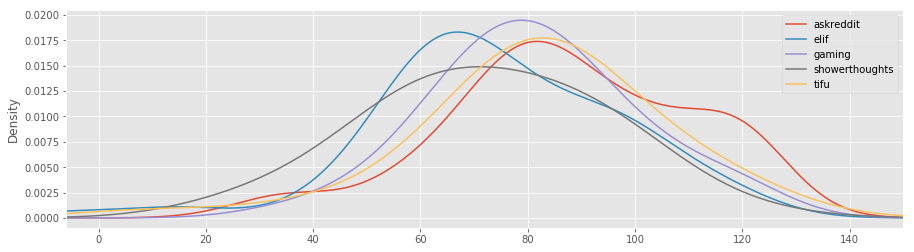

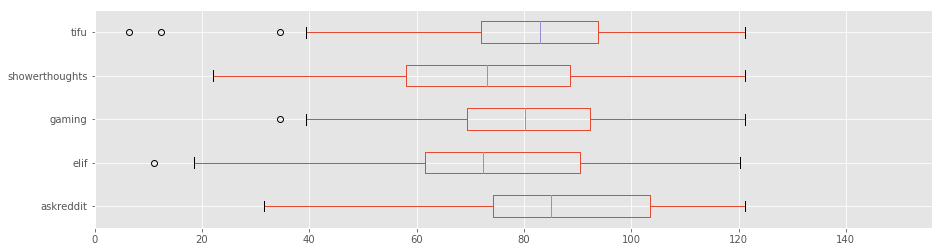

In [22]:
df.plot.kde(xlim=[-6,150])
df.plot.box(vert=False, xlim=[0, 156])